<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-series forecasting with TensorFlow

What are we going to cover?
1. Get a time series data (the historical price of Bitcoin)
  * Load time series data using Pandas/Python CSV
2. Format data for a time series problem
  * Creating a training and test set wrong way
  * Creating a training and test set right way
  * Visualizing time series data
  * Turning time series model into supervised learning problem ( Windowing )
  * Preparing Univariate and Multivariable ( more than one variable ) data

3. Evaluating a time series model
4. Setting up a series for deep leaning modelling experiments
  * Dense fully connected
  * Sequence model ( LSTM and 1D CNN )
  * Ensembling ( combining multiple models together )
  * Multivariate models
  * Replicating the N-Beats algorithm using Tensorflow Layer subclassing
5. Creating a modelling checkpoint to save best performing model
6. Making predictions (forecast) with time series model.
7. Creating prediction intervals for time series forecasts.


## 1. Get the data

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-27 23:24:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-27 23:24:14 (7.30 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### 1.1 Import time series data with Pandas

In [ ]:
import pandas as pd
price_df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
                 ,parse_dates=["Date"]
                 ,index_col=["Date"]
                 )

price_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
len(price_df)

2787

🔑note: The frequency at which time series data is collected is often referred to as **seasonality**. Seasonality is often measured as number of samples / year.

In [ ]:
# We only want the closing price
daily_price_df = pd.DataFrame(price_df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


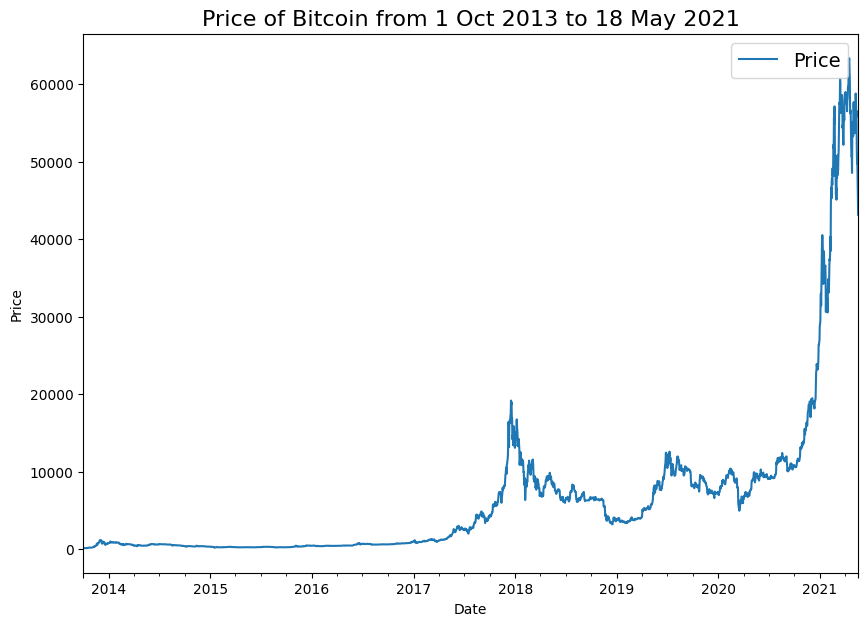

In [ ]:
import matplotlib.pyplot as plt
daily_price_df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## 2. Creating the training and test set
### 2.1 The wrong way

In [ ]:
# Convert our dataframe index and columns to numpy arrays
timesteps = daily_price_df.index.to_numpy()
prices = daily_price_df["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(timesteps
                                                   ,prices
                                                   ,test_size=0.2
                                                   ,random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### 2.2 Let's visualize the splits

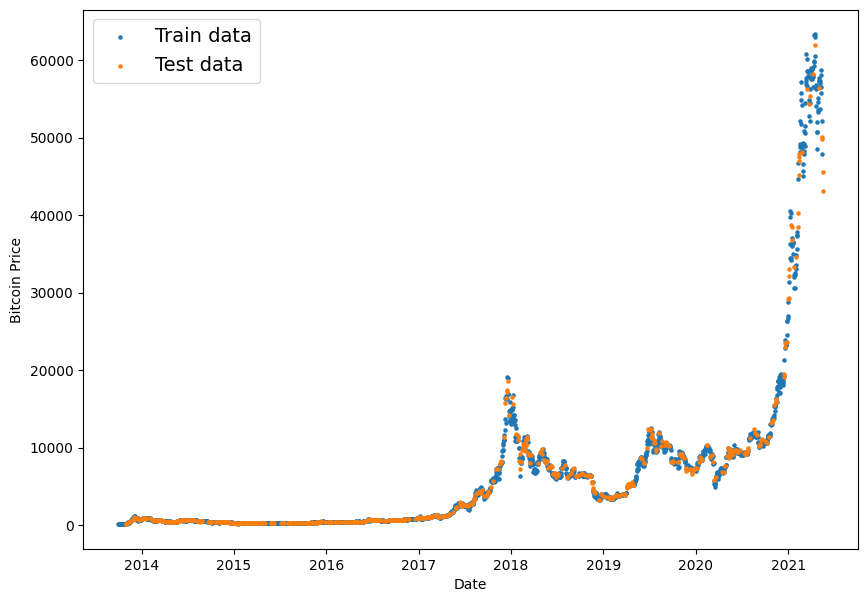

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

As we can see in the above plot our test data is scattered across the training data. This kind of random split works great with data where there is no temporal (time) component. But when time component is invovled, we need to split the data in such a way that it should reflect our purpose. The purpose here is to analyze the historical price and predict or forecast the future price.

### 2.3 Creating the train test split the right way

In [ ]:
split_size = int(0.8* len(prices))

X_train,y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

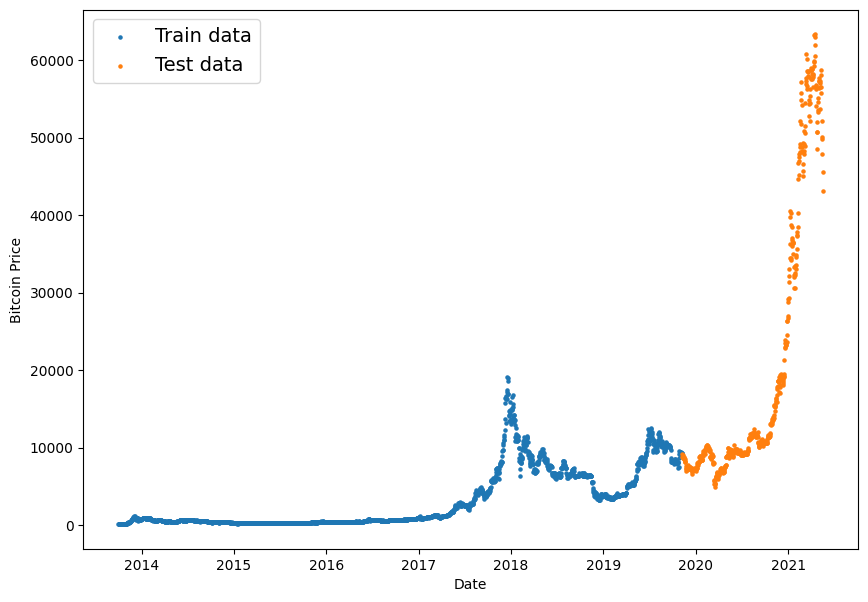

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

## Model 0: Navive Forecast ( baseline )
As usual lets start with a baseline.
One of the most common baseline for time series forecasting, the naive model requires no training.
That's because all that the naive model does is forecast the next timestep value based on previous timestep value.
The formula looks like:

̂y<sub>t</sub> = y<sub>t</sub> -1

In [ ]:
# create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
# Create a plotting function

def plot_time_series(timesteps,values,format='.', start=0, end=None, label=None):
  """
    Plots a timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    -------------
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot ( setting a value will index from start of timesteps and values)
    end: where to end the plot (setting a value will index from end of timesteps & values )
    label: label to show on plot of values
  """
  ## Plot the series
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

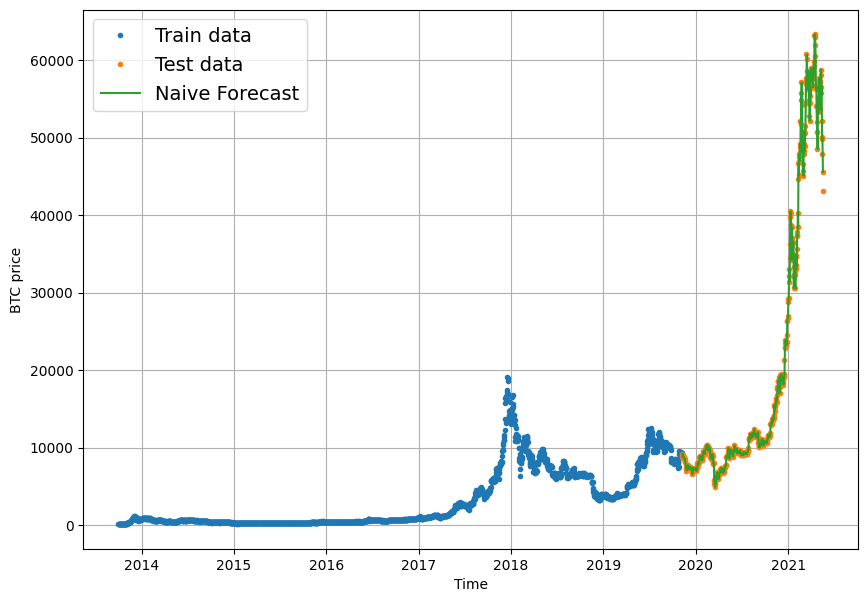

In [ ]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

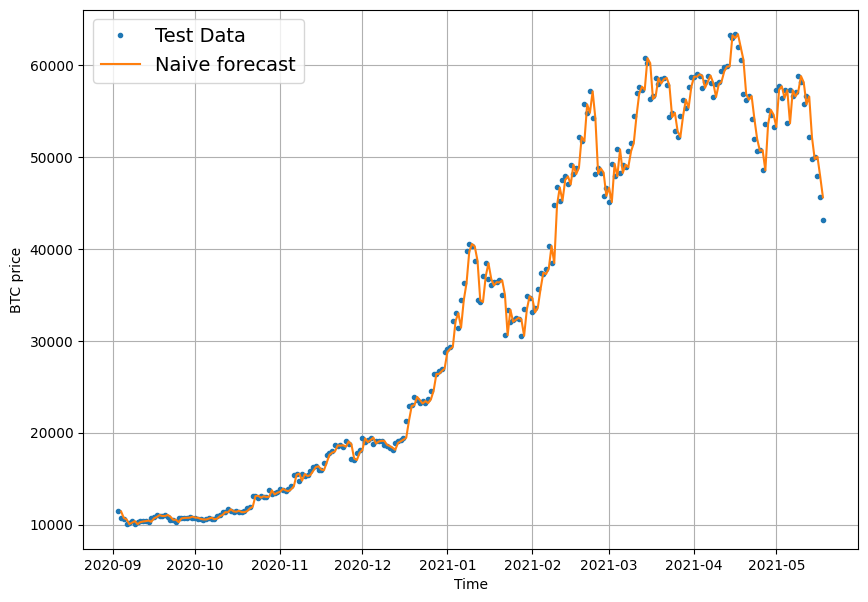

In [ ]:
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test,values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", start=offset, label="Naive forecast")

## Evaluate a time series model
Time series forecasting often involves predicting a number.
As the problem statement is about predicting a number, it comes under **regression**
For all the following metrics **lower is better** ( for e.g MAE 0 is better than MAE 100)

### Scale-depdendent errors
These are metrics which can be used to compare time series values and forecast that are on the same scale

Metrics| Details|Code
---|---|---
MAE ( Mean Absolute Error ) | Easy to interpret. Forecast methods which minimizes the <br> MAE will lead to forecasts of the median |`tf.keras.metrics.mean_absolute_error()`
RMSE(Root Mean Squared Error ) | Forecast which minimizes the RMSE lead to forecasts <br> to the mean| `tf.keras.metrics.mean_squared_error()`

### Percentage Errors
Percentage errors do not have units, which mean they can be used to compare forecasts across different units.

Metrics|Details|Code
---|---|---
**MAPE**(Mean Absolute Percentage Error)|Most commonly used percentage error|`tf.keras.metrics.mean_absolute_percentage_error`
**sMAPE**(symmetric Mean Absolute Percentage Error)| Recommend not to use|Custom implementation

### Scaled Errors
Scaled errors are alternative to percentage errors when comparing forecasting performance across different timeseries

Metrics|Details|Code
---|---|---
MASE(mean absolute scaled error)|A forecast which performs better than naive should get <1 MASE|See sktimes<br> `mase_loss()`


In [ ]:
import tensorflow as tf


In [ ]:
# MASE implemented
def mean_absolute_scaled_error(y_true, y_pred):
  """
    Implement MASE ( assuming no seasonality data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  ## find MAE for naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/mae_naive_no_season

> In practice the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of > 1 and any model better than naive forecast will achieve and MASE of < 1

Let's put each of our different evaluation metrics together into a function

In [ ]:
def evaluate_pred(y_true,y_pred):
  #Make sure float32 ( for metric calculation)
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  return {
      "mae": mae.numpy()
      ,"mse": mse.numpy()
      ,"rmse": rmse.numpy()
      ,"mape": mape.numpy()
      ,"mase": mase.numpy()
  }

In [ ]:
naive_results= evaluate_pred(y_true=y_test[1:]
                             ,y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Looking at the MAE results, we can infer that on an average the predicted bitcoin price is off from the actual price by about ~567 USD.

## Format Data Part2: Windowing dataset
**Windowing** is a method to turn a time series dataset to _supervised learning problem_.
In other words, we want to use windows of the past to predict the future.
For example, for a univariate time series, windowing for one week(`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

Let's write a function that can take a univariate time series and turn into windows and horizon of specified sizes.

We'll start the default horizon size of 1 and window size of 7


In [ ]:
HORIZON= 1 # predict 1 timestep at a time
WINDOW_SIZE= 7 #use a week worth of timesteps to predict the horizon

Now we will write a function that will take an array and return a window and horizon


In [ ]:
# Create a function to create labelled window data
def get_labelled_windows(x,horizon=1):
  """
    Creates a label for window dataset
    E.g if horizon=1 (default)
    Input: [1,2,3,4,5,6] -> Output ([1,2,3,4,5],[6])
  """
  return (x[:,:-horizon],x[:, -horizon:])

In [ ]:
# Test the window labelling function
test_window, test_label= get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


#### Make window for the entire timeseries
Let's write a function which:
1. Create a window step of specific window size, for example `[[0,1,2,3,4,5,6]]`
2. Uses [Numpy Indexing]() to create a 2D of multiple window steps, for example
```
[[0,1,2,3,4,5,6,7]
 [1,2,3,4,5,6,7,8]
 [2,3,4,5,6,7,8,9]]
```
3. Uses the 2D array of multiple window steps to index to a target series.
4. Uses the `get_labelled_window` function we created above to turn the window steps into windows with a specified horizon.

In [ ]:
import numpy as np

In [ ]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
   Turns a 1D array into a 2D array of sequential windows of a given window size.
  """
  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)
  # 2. Create a 2D array of multiple window steps
  window_indexes= window_step+ np.expand_dims(np.arange(len(x)- window_size+horizon-1),axis=0).T
  # 3. Index on the target array with 2D array of multiple window steps
  windowed_array= x[window_indexes]
  # 4. Get the labelled windows
  windows, labels= get_labelled_windows(windowed_array,horizon=horizon)
  return windows,labels

In [ ]:
np.expand_dims(np.arange(7+1),0).T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [ ]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
## view the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]}, Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


We can use tensorflow inbuilt functions to achieve the same output. We need to use `tf.keras.preprocessing.timeseries_dataset_from_array()`

TODO: We will look into this later.

### Turning windows into training and test set
Let's write a function that takes a full set of windows and their labels and splits them into train & test splits.

In [ ]:
# Make the train/test split
def make_train_test_split(windows,labels,test_split=0.2):
  """
    Splits matching pairs of windows and labels into train and test split.

  """
  split_size= int(len(windows) * (1-test_split))

  train_windows= windows[:split_size]
  train_labels= labels[:split_size]
  test_windows= windows[split_size:]
  test_labels= labels[split_size:]

  return train_windows, train_labels, test_windows,test_labels


In [ ]:
train_windows, train_labels, test_windows,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows), len(test_windows),  len(train_labels),len(test_labels)


(2224, 556, 2224, 556)

In [ ]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Making a model checkpoint
The `ModelCheckpoint` callback will monitor our model performance during the training and saves the best model to the file system by setting `save_best_only=True`

In [ ]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name)
                                            ,verbose=0
                                            ,save_best_only=True)

## Model 1: Dense Model ( window = 7, horizon = 1)
Time to build one of our models

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation unit.
* An output layer with linear activation.
* Adam optimizer with MAE loss
* Batch size of 128
* 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

## set seed
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation=tf.keras.activations.relu)
    ,layers.Dense(HORIZON,activation=tf.keras.activations.linear)
],name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mean_absolute_error
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"]
                )

history_1= model_1.fit(x=train_windows
                       ,y=train_labels
                       ,epochs=100
                       ,verbose=1
                       ,batch_size=128
                       ,validation_data=(test_windows,test_labels)
                       ,callbacks=[create_model_checkpoint(model_name=model_1.name)]
                       )



Epoch 1/100
 1/18 [>.............................] - ETA: 9s - loss: 4484.0469 - mae: 4484.0469

18/18 [==============================] - 1s 48ms/step - loss: 2072.4587 - mae: 2072.4587 - val_loss: 1655.2394 - val_mae: 1655.2394
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 449.9562 - mae: 449.9562 - val_loss: 2307.6875 - val_mae: 2307.6875
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 308.5726 - mae: 308.5726

18/18 [==============================] - 1s 39ms/step - loss: 273.5443 - mae: 273.5443 - val_loss: 1311.7064 - val_mae: 1311.7064
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 272.2764 - mae: 272.2764

18/18 [==============================] - 1s 37ms/step - loss: 216.8738 - mae: 216.8738 - val_loss: 1180.6146 - val_mae: 1180.6146
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 193.5980 - mae: 193.5980

18/18 [==============================] - 1s 42ms/step - loss: 209.2532 - mae: 209.2532 - val_loss: 1175.0481 - val_mae: 1175.0481
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 155.8885 - mae: 155.8885

18/18 [==============================] - 1s 39ms/step - loss: 197.3655 - mae: 197.3655 - val_loss: 1090.3442 - val_mae: 1090.3442
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 239.8273 - mae: 239.8273

18/18 [==============================] - 1s 61ms/step - loss: 190.7315 - mae: 190.7315 - val_loss: 1073.0914 - val_mae: 1073.0914
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 160.6720 - mae: 160.6720

18/18 [==============================] - 1s 39ms/step - loss: 183.8749 - mae: 183.8749 - val_loss: 1020.6396 - val_mae: 1020.6396
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 145.0934 - mae: 145.0934

18/18 [==============================] - 1s 38ms/step - loss: 179.9046 - mae: 179.9046 - val_loss: 1017.5096 - val_mae: 1017.5096
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 190.0373 - mae: 190.0373

18/18 [==============================] - 1s 44ms/step - loss: 175.4215 - mae: 175.4215 - val_loss: 980.1496 - val_mae: 980.1496
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 168.4407 - mae: 168.4407

18/18 [==============================] - 1s 56ms/step - loss: 168.2519 - mae: 168.2519 - val_loss: 928.6438 - val_mae: 928.6438
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 161.5949 - mae: 161.5949 - val_loss: 1029.5776 - val_mae: 1029.5778
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 159.2992 - mae: 159.2992 - val_loss: 971.2962 - val_mae: 971.2962
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 151.6669 - mae: 151.6669

18/18 [==============================] - 1s 55ms/step - loss: 154.4109 - mae: 154.4109 - val_loss: 894.5269 - val_mae: 894.5269
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 148.1554 - mae: 148.1554

18/18 [==============================] - 1s 40ms/step - loss: 148.1554 - mae: 148.1554 - val_loss: 814.4669 - val_mae: 814.4669
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 135.3338 - mae: 135.3338

18/18 [==============================] - 1s 36ms/step - loss: 142.0452 - mae: 142.0452 - val_loss: 793.2522 - val_mae: 793.2522
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 140.7014 - mae: 140.7014 - val_loss: 802.2610 - val_mae: 802.2610
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 140.4762 - mae: 140.4762 - val_loss: 845.6437 - val_mae: 845.6437
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 134.7144 - mae: 134.7144 - val_loss: 835.7392 - val_mae: 835.7392
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 148.9956 - mae: 148.9956

18/18 [==============================] - 1s 38ms/step - loss: 132.6932 - mae: 132.6932 - val_loss: 730.9480 - val_mae: 730.9479
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 172.8282 - mae: 172.8282

18/18 [==============================] - 1s 37ms/step - loss: 132.6693 - mae: 132.6693 - val_loss: 716.7968 - val_mae: 716.7968
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 128.0967 - mae: 128.0967 - val_loss: 722.2093 - val_mae: 722.2093
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 126.1123 - mae: 126.1123

18/18 [==============================] - 1s 36ms/step - loss: 127.9418 - mae: 127.9418 - val_loss: 696.8690 - val_mae: 696.8690
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 138.3152 - mae: 138.3152

18/18 [==============================] - 1s 37ms/step - loss: 126.7910 - mae: 126.7910 - val_loss: 682.2964 - val_mae: 682.2964
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 125.2836 - mae: 125.2836

18/18 [==============================] - 1s 38ms/step - loss: 124.1037 - mae: 124.1037 - val_loss: 673.7326 - val_mae: 673.7326
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 124.7318 - mae: 124.7318

18/18 [==============================] - 1s 36ms/step - loss: 123.7176 - mae: 123.7176 - val_loss: 665.6469 - val_mae: 665.6469
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 123.2939 - mae: 123.2939 - val_loss: 668.3240 - val_mae: 668.3240
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 120.7064 - mae: 120.7064 - val_loss: 671.0621 - val_mae: 671.0621
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 112.6219 - mae: 112.6219

18/18 [==============================] - 1s 37ms/step - loss: 123.8968 - mae: 123.8968 - val_loss: 645.0730 - val_mae: 645.0730
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 132.3640 - mae: 132.3640

18/18 [==============================] - 1s 36ms/step - loss: 124.7720 - mae: 124.7720 - val_loss: 644.4996 - val_mae: 644.4996
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 116.8382 - mae: 116.8382 - val_loss: 668.0569 - val_mae: 668.0569
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 118.4436 - mae: 118.4436

18/18 [==============================] - 1s 61ms/step - loss: 116.9605 - mae: 116.9605 - val_loss: 631.1653 - val_mae: 631.1653
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1641 - mae: 116.1641 - val_loss: 665.5618 - val_mae: 665.5618
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 116.6976 - mae: 116.6976 - val_loss: 639.1680 - val_mae: 639.1680
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9285 - mae: 113.9285 - val_loss: 635.6187 - val_mae: 635.6187
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 164.3644 - mae: 164.3644

18/18 [==============================] - 1s 37ms/step - loss: 116.3276 - mae: 116.3276 - val_loss: 613.2930 - val_mae: 613.2930
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 134.9868 - mae: 134.9868

18/18 [==============================] - 1s 37ms/step - loss: 115.1226 - mae: 115.1226 - val_loss: 611.2570 - val_mae: 611.2570
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1030 - mae: 114.1030 - val_loss: 622.1312 - val_mae: 622.1312
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 132.5607 - mae: 132.5607

18/18 [==============================] - 1s 47ms/step - loss: 114.0236 - mae: 114.0236 - val_loss: 606.2267 - val_mae: 606.2267
Epoch 40/100
16/18 [=========================>....] - ETA: 0s - loss: 111.9828 - mae: 111.9828

18/18 [==============================] - 1s 55ms/step - loss: 111.5858 - mae: 111.5858 - val_loss: 601.4215 - val_mae: 601.4215
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7303 - mae: 111.7303 - val_loss: 602.9898 - val_mae: 602.9898
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2328 - mae: 114.2328 - val_loss: 638.9105 - val_mae: 638.9105
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3165 - mae: 114.3165 - val_loss: 638.5380 - val_mae: 638.5380
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 112.0259 - mae: 112.0259

18/18 [==============================] - 1s 55ms/step - loss: 112.0259 - mae: 112.0259 - val_loss: 586.9832 - val_mae: 586.9832
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9646 - mae: 109.9646 - val_loss: 592.5984 - val_mae: 592.5984
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9994 - mae: 111.9994 - val_loss: 616.1850 - val_mae: 616.1850
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5087 - mae: 114.5087 - val_loss: 610.5009 - val_mae: 610.5009
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1440 - mae: 110.1440 - val_loss: 595.9713 - val_mae: 595.9713
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 113.3377 - mae: 113.3377 - val_loss: 609.2538 - val_mae: 609.2538
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1432 - mae: 116.1432 - val_loss: 650.5400 - val_mae: 650.5400
Epoch 51/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 114.4340 - mae: 114.4340 - val_loss: 584.3478 - val_mae: 584.3478
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6895 - mae: 110.6895 - val_loss: 638.3386 - val_mae: 638.3386
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 107.3284 - mae: 107.3284

18/18 [==============================] - 1s 36ms/step - loss: 110.7643 - mae: 110.7643 - val_loss: 579.8644 - val_mae: 579.8644
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9292 - mae: 113.9292 - val_loss: 597.2839 - val_mae: 597.2839
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9291 - mae: 111.9291 - val_loss: 789.5436 - val_mae: 789.5436
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 128.0115 - mae: 128.0115 - val_loss: 631.3500 - val_mae: 631.3500
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 120.3102 - mae: 120.3102 - val_loss: 659.1815 - val_mae: 659.1815
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7835 - mae: 113.7835 - val_loss: 656.1085 - val_mae: 656.1085
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9044 - mae: 113.9044 - val_loss: 682.7517 - val_mae: 682.7517
Epoch 61/100
 1/18 [>...........

18/18 [==============================] - 1s 37ms/step - loss: 111.2712 - mae: 111.2712 - val_loss: 573.2762 - val_mae: 573.2762
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 73.9498 - mae: 73.9498

18/18 [==============================] - 1s 38ms/step - loss: 106.7057 - mae: 106.7057 - val_loss: 570.5534 - val_mae: 570.5534
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 89.9750 - mae: 89.9750

18/18 [==============================] - 1s 37ms/step - loss: 108.1693 - mae: 108.1693 - val_loss: 569.8910 - val_mae: 569.8910
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 106.9611 - mae: 106.9611 - val_loss: 666.8349 - val_mae: 666.8349
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6863 - mae: 117.6863 - val_loss: 597.6945 - val_mae: 597.6945
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 120.7222 - mae: 120.7222

18/18 [==============================] - 1s 38ms/step - loss: 109.3348 - mae: 109.3348 - val_loss: 569.2255 - val_mae: 569.2255
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 105.6815 - mae: 105.6815 - val_loss: 637.6056 - val_mae: 637.6056
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3201 - mae: 112.3201 - val_loss: 648.0038 - val_mae: 648.0038
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 120.0777 - mae: 120.0777 - val_loss: 700.5358 - val_mae: 700.5358
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 131.0706 - mae: 131.0706 - val_loss: 694.9090 - val_mae: 694.9090
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3916 - mae: 121.3916 - val_loss: 590.8796 - val_mae: 590.8796
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3456 - mae: 110.3456 - val_loss: 581.1583 - val_mae: 581.1583
Epoch 73/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 117.6177 - mae: 117.6177 - val_loss: 567.0255 - val_mae: 567.0255
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2115 - mae: 114.2115 - val_loss: 695.3563 - val_mae: 695.3563
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6356 - mae: 114.6356 - val_loss: 568.4750 - val_mae: 568.4750
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 108.1980 - mae: 108.1980 - val_loss: 567.1545 - val_mae: 567.1545
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 107.0754 - mae: 107.0754 - val_loss: 570.8162 - val_mae: 570.8162
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 105.6515 - mae: 105.6515 - val_loss: 580.9564 - val_mae: 580.9564
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 106.3959 - mae: 106.3959 - val_loss: 569.0807 - val_mae: 569.0807
Epoch 89/100
 1/18 [>...........

18/18 [==============================] - 1s 35ms/step - loss: 106.1459 - mae: 106.1459 - val_loss: 563.5523 - val_mae: 563.5523
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5183 - mae: 105.5183 - val_loss: 598.5599 - val_mae: 598.5599
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0172 - mae: 110.0172 - val_loss: 578.3920 - val_mae: 578.3920
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0705 - mae: 110.0705 - val_loss: 566.3077 - val_mae: 566.3077
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 118.1133 - mae: 118.1133 - val_loss: 617.8469 - val_mae: 617.8469
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 115.1866 - mae: 115.1866 - val_loss: 603.8304 - val_mae: 603.8304
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2335 - mae: 107.2335 - val_loss: 565.1974 - val_mae: 565.1974
Epoch 96/100
18/18 [============

In [ ]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 670.2364 - mae: 670.2364


[670.2363891601562, 670.2363891601562]

In [ ]:
# Load in best saved model and evaluate on test data
saved_model_1 = tf.keras.models.load_model("model_experiment/model_1_dense")
saved_model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 563.5522 - mae: 563.5522


[563.55224609375, 563.55224609375]

## Making forecast with a model ( on test dataset )
Since we are going to run more modelling experiments, lets write a function which can return the predictions given a model and input data

* Take a trained model
* Take in some input data
* Pass the input data to the model
* Returns the prediction

In [ ]:
def make_preds(model,input_data):
  """
    Uses model to make predictions on input data

    Args:
      model: trained model
      input_data: windowed input data ( same kind as the model is trained on)
    Returns:
      model prediction on input data
  """
  return tf.squeeze(model.predict(input_data))

In [ ]:
model_1_preds = make_preds(model_1,test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 7ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8670.272, 8624.59 , 8865.709, 8586.955, 8595.436, 8570.949,
        8503.167, 8365.449, 8303.16 , 8367.681], dtype=float32)>,
 556)

### Now lets evaluate our model using the `evaluate_model` method we create above in this notebook

In [ ]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [ ]:
evaluate_pred?

In [ ]:
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels)
                                ,y_pred=model_1_preds)
model_1_results

{'mae': 670.2364,
 'mse': 1384025.6,
 'rmse': 1176.4462,
 'mape': 3.0963743,
 'mase': 1.1774197}

### Let us use the `plot_time_series` function to plot the `model_1_preds` against the test_data

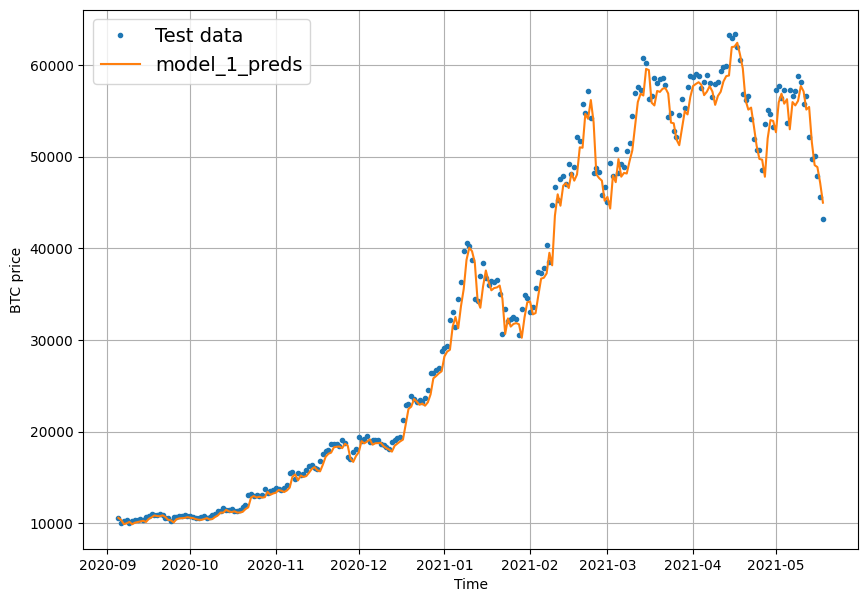

In [ ]:
offset= 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds
                 ,start=offset,label="model_1_preds",format="-")


## Model 2: Window size=30, Horizon=1
We will start with our second modelling experiment where the window size=30 and horizon=1

We will use the functions we have created earlier to create our train/test feature and train/test labels


In [ ]:
HORIZON=1
WINDOW_SIZE=30

In [ ]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE
                                         ,horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
train_window, train_label, test_window , test_label=make_train_test_split(full_windows
                                                                         ,full_labels
                                                                         ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)


(2205, 2205, 552, 552)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_2_Dense")

model_2.compile(loss="mae"
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["mae"]
                 )
history_2 = model_2.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_2.name)])





Epoch 1/100
56/69 [=======================>......] - ETA: 0s - loss: 620.1631 - mae: 620.1631

69/69 [==============================] - 2s 16ms/step - loss: 551.4172 - mae: 551.4172 - val_loss: 1083.5880 - val_mae: 1083.5880
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 218.5343 - mae: 218.5343 - val_loss: 1337.0811 - val_mae: 1337.0811
Epoch 3/100
65/69 [===========================>..] - ETA: 0s - loss: 179.6153 - mae: 179.6153

69/69 [==============================] - 1s 21ms/step - loss: 178.8003 - mae: 178.8003 - val_loss: 901.9918 - val_mae: 901.9918
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 214.4983 - mae: 214.4983 - val_loss: 972.3517 - val_mae: 972.3517
Epoch 5/100
43/69 [=================>............] - ETA: 0s - loss: 157.4948 - mae: 157.4948

69/69 [==============================] - 1s 11ms/step - loss: 163.3219 - mae: 163.3219 - val_loss: 792.3395 - val_mae: 792.3395
Epoch 6/100
52/69 [=====================>........] - ETA: 0s - loss: 169.9726 - mae: 169.9726

69/69 [==============================] - 1s 11ms/step - loss: 161.4892 - mae: 161.4892 - val_loss: 789.0844 - val_mae: 789.0844
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 168.6597 - mae: 168.6597 - val_loss: 1024.2445 - val_mae: 1024.2445
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 148.2304 - mae: 148.2304 - val_loss: 959.1981 - val_mae: 959.1981
Epoch 9/100
52/69 [=====================>........] - ETA: 0s - loss: 148.8140 - mae: 148.8140

69/69 [==============================] - 1s 11ms/step - loss: 151.7644 - mae: 151.7644 - val_loss: 711.5560 - val_mae: 711.5560
Epoch 10/100
58/69 [========================>.....] - ETA: 0s - loss: 148.4801 - mae: 148.4801

69/69 [==============================] - 1s 11ms/step - loss: 144.7743 - mae: 144.7743 - val_loss: 702.4862 - val_mae: 702.4862
Epoch 11/100
59/69 [========================>.....] - ETA: 0s - loss: 149.8535 - mae: 149.8535

69/69 [==============================] - 1s 11ms/step - loss: 147.0139 - mae: 147.0139 - val_loss: 682.6910 - val_mae: 682.6910
Epoch 12/100
69/69 [==============================] - 0s 3ms/step - loss: 136.3236 - mae: 136.3236 - val_loss: 819.9323 - val_mae: 819.9323
Epoch 13/100
69/69 [==============================] - 0s 3ms/step - loss: 143.6075 - mae: 143.6075 - val_loss: 905.7053 - val_mae: 905.7053
Epoch 14/100
69/69 [==============================] - 0s 3ms/step - loss: 139.9405 - mae: 139.9405 - val_loss: 724.4088 - val_mae: 724.4088
Epoch 15/100
69/69 [==============================] - 0s 3ms/step - loss: 196.9353 - mae: 196.9353 - val_loss: 1382.9548 - val_mae: 1382.9548
Epoch 16/100
69/69 [==============================] - 0s 3ms/step - loss: 153.1789 - mae: 153.1789 - val_loss: 1174.4281 - val_mae: 1174.4281
Epoch 17/100
69/69 [==============================] - 0s 3ms/step - loss: 167.6864 - mae: 167.6864 - val_loss: 729.4026 - val_mae: 729.4026
Epoch 18/100
56/69 [========

69/69 [==============================] - 1s 11ms/step - loss: 149.1245 - mae: 149.1245 - val_loss: 630.4102 - val_mae: 630.4102
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 138.7013 - mae: 138.7013 - val_loss: 1367.8477 - val_mae: 1367.8477
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 161.1037 - mae: 161.1037 - val_loss: 895.1210 - val_mae: 895.1210
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 147.9379 - mae: 147.9379 - val_loss: 910.4041 - val_mae: 910.4041
Epoch 22/100
69/69 [==============================] - 0s 3ms/step - loss: 148.7256 - mae: 148.7256 - val_loss: 636.0518 - val_mae: 636.0518
Epoch 23/100
69/69 [==============================] - 0s 3ms/step - loss: 151.7493 - mae: 151.7493 - val_loss: 1461.2512 - val_mae: 1461.2512
Epoch 24/100
69/69 [==============================] - 0s 3ms/step - loss: 180.7482 - mae: 180.7482 - val_loss: 772.6065 - val_mae: 772.6065
Epoch 25/100
69/69 [========

69/69 [==============================] - 1s 11ms/step - loss: 145.6409 - mae: 145.6409 - val_loss: 611.2093 - val_mae: 611.2093
Epoch 28/100
69/69 [==============================] - 0s 3ms/step - loss: 146.0807 - mae: 146.0807 - val_loss: 751.6107 - val_mae: 751.6107
Epoch 29/100
69/69 [==============================] - 0s 3ms/step - loss: 124.8781 - mae: 124.8781 - val_loss: 661.9066 - val_mae: 661.9066
Epoch 30/100
69/69 [==============================] - 0s 3ms/step - loss: 142.3227 - mae: 142.3227 - val_loss: 676.3108 - val_mae: 676.3108
Epoch 31/100
69/69 [==============================] - 0s 3ms/step - loss: 127.0674 - mae: 127.0674 - val_loss: 633.9117 - val_mae: 633.9117
Epoch 32/100
69/69 [==============================] - 0s 3ms/step - loss: 130.3732 - mae: 130.3732 - val_loss: 777.4150 - val_mae: 777.4150
Epoch 33/100
69/69 [==============================] - 0s 3ms/step - loss: 119.9974 - mae: 119.9974 - val_loss: 816.9276 - val_mae: 816.9276
Epoch 34/100
69/69 [============

69/69 [==============================] - 1s 13ms/step - loss: 131.6156 - mae: 131.6156 - val_loss: 592.6143 - val_mae: 592.6143
Epoch 43/100
69/69 [==============================] - 0s 3ms/step - loss: 137.4030 - mae: 137.4030 - val_loss: 601.9695 - val_mae: 601.9695
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 120.8819 - mae: 120.8819 - val_loss: 614.7012 - val_mae: 614.7012
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 136.4604 - mae: 136.4604 - val_loss: 1370.8997 - val_mae: 1370.8997
Epoch 46/100
69/69 [==============================] - 0s 3ms/step - loss: 139.3648 - mae: 139.3648 - val_loss: 655.4042 - val_mae: 655.4042
Epoch 47/100
69/69 [==============================] - 0s 3ms/step - loss: 125.2048 - mae: 125.2048 - val_loss: 1443.2543 - val_mae: 1443.2543
Epoch 48/100
69/69 [==============================] - 0s 3ms/step - loss: 154.1074 - mae: 154.1074 - val_loss: 624.4426 - val_mae: 624.4426
Epoch 49/100
69/69 [========

69/69 [==============================] - 1s 11ms/step - loss: 114.2347 - mae: 114.2347 - val_loss: 591.3126 - val_mae: 591.3126
Epoch 60/100
69/69 [==============================] - 0s 2ms/step - loss: 121.9808 - mae: 121.9808 - val_loss: 621.6407 - val_mae: 621.6407
Epoch 61/100
69/69 [==============================] - 0s 3ms/step - loss: 132.8565 - mae: 132.8565 - val_loss: 742.1337 - val_mae: 742.1337
Epoch 62/100
69/69 [==============================] - 0s 2ms/step - loss: 123.1428 - mae: 123.1428 - val_loss: 738.4547 - val_mae: 738.4547
Epoch 63/100
69/69 [==============================] - 0s 3ms/step - loss: 126.2953 - mae: 126.2953 - val_loss: 746.5279 - val_mae: 746.5279
Epoch 64/100
69/69 [==============================] - 0s 3ms/step - loss: 121.2062 - mae: 121.2062 - val_loss: 855.7368 - val_mae: 855.7368
Epoch 65/100
69/69 [==============================] - 0s 3ms/step - loss: 120.8023 - mae: 120.8023 - val_loss: 638.7488 - val_mae: 638.7488
Epoch 66/100
69/69 [============

69/69 [==============================] - 1s 10ms/step - loss: 138.4197 - mae: 138.4197 - val_loss: 589.3622 - val_mae: 589.3622
Epoch 70/100
69/69 [==============================] - 0s 3ms/step - loss: 118.1580 - mae: 118.1580 - val_loss: 694.0253 - val_mae: 694.0253
Epoch 71/100
69/69 [==============================] - 0s 3ms/step - loss: 140.1487 - mae: 140.1487 - val_loss: 856.5816 - val_mae: 856.5816
Epoch 72/100
69/69 [==============================] - 0s 3ms/step - loss: 145.7947 - mae: 145.7947 - val_loss: 594.8990 - val_mae: 594.8990
Epoch 73/100
69/69 [==============================] - 0s 3ms/step - loss: 128.8797 - mae: 128.8797 - val_loss: 600.1854 - val_mae: 600.1854
Epoch 74/100
69/69 [==============================] - 0s 3ms/step - loss: 122.0327 - mae: 122.0327 - val_loss: 623.8476 - val_mae: 623.8476
Epoch 75/100
69/69 [==============================] - 0s 2ms/step - loss: 121.7906 - mae: 121.7906 - val_loss: 1124.9452 - val_mae: 1124.9452
Epoch 76/100
69/69 [==========

69/69 [==============================] - 1s 15ms/step - loss: 127.6353 - mae: 127.6353 - val_loss: 587.0542 - val_mae: 587.0542
Epoch 87/100
69/69 [==============================] - 0s 4ms/step - loss: 126.8219 - mae: 126.8219 - val_loss: 626.7807 - val_mae: 626.7807
Epoch 88/100
69/69 [==============================] - 0s 4ms/step - loss: 119.5884 - mae: 119.5884 - val_loss: 627.4825 - val_mae: 627.4825
Epoch 89/100
69/69 [==============================] - 0s 4ms/step - loss: 116.7887 - mae: 116.7887 - val_loss: 775.7974 - val_mae: 775.7974
Epoch 90/100
69/69 [==============================] - 0s 4ms/step - loss: 138.0076 - mae: 138.0076 - val_loss: 602.5238 - val_mae: 602.5238
Epoch 91/100
69/69 [==============================] - 0s 3ms/step - loss: 134.6242 - mae: 134.6242 - val_loss: 739.1082 - val_mae: 739.1082
Epoch 92/100
69/69 [==============================] - 0s 3ms/step - loss: 114.9013 - mae: 114.9013 - val_loss: 711.4137 - val_mae: 711.4137
Epoch 93/100
69/69 [============

69/69 [==============================] - 1s 11ms/step - loss: 126.0161 - mae: 126.0161 - val_loss: 584.6978 - val_mae: 584.6978
Epoch 98/100
69/69 [==============================] - 0s 3ms/step - loss: 137.9169 - mae: 137.9169 - val_loss: 596.5149 - val_mae: 596.5149
Epoch 99/100
69/69 [==============================] - 0s 3ms/step - loss: 119.1559 - mae: 119.1559 - val_loss: 594.6257 - val_mae: 594.6257
Epoch 100/100
69/69 [==============================] - 0s 3ms/step - loss: 128.1882 - mae: 128.1882 - val_loss: 631.8973 - val_mae: 631.8973
